In [1]:
from xai.dqn_autoencoder import DQN
from xai.stream import Stream
from xai.bytes import GigaBytes
import torch
import shap
from torch import Tensor
from xai.window import Window
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from xai.record import Recorder

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
dqn = DQN(autoencoder_path="autoencoder-l32.pt",translate=True, rotate=True, device="cpu") 

In [ ]:
dqn = DQN.load("dqn-model-Copy1.pt") 

In [ ]:
dqn.train(
    total_time_steps=1_000_000,
    replay_buffer_size=GigaBytes(8),
    learning_rate = 1e-4,
    learning_starts = 100,
    batch_size = 32,
    tau = 1.0,
    gamma = 0.99,
    train_frequency = 32,
    frame_skip=4,
    gradient_steps = 2,
    save_path= "./dqn-model.pt",
    target_update_frequency = 1000,
    final_exploration_rate_progress = 0.03,
    initial_exploration_rate = 1.0,
    final_exploration_rate = 0.05,
    verbose = True
)

In [15]:
with Window("Asteroids", 60, 4.0) as window, tqdm(total=7000) as bar:
    for step in dqn.rollout(0.0, frame_skips=2).take(7000):
        obs = step.observation.numpy(True)
        translated = step.observation.translated().numpy(True)
        rotated = step.observation.translated().rotated().numpy(True)
        tensor = step.observation.translated().rotated().tensor(normalize=True, device="cuda").unsqueeze(0)
        decode = dqn._autoencoder(tensor).squeeze(0).numpy(force=True)
        window(np.hstack([obs,rotated,decode])).match({
            "q": lambda: window.break_window(),
            "p": lambda: (
                plt.imsave("images/observation.png", obs),
                plt.imsave("images/translated.png", translated),
                plt.imsave("images/rotated.png", rotated),
                plt.imsave("images/decode.png", decode),
                ),
            None: lambda: None
        })
        bar.update()

 50%|█████     | 3517/7000 [01:50<01:49, 31.80it/s]


WindowClosed: 

In [8]:
from xai.dqn_autoencoder import DQN
from xai.stream import Stream
from xai.bytes import GigaBytes
import torch
import shap
from torch import Tensor
from xai.window import Window
import numpy as np
import matplotlib.pyplot as plt

dqn = DQN.load("dqn-model-Copy1.pt") 
number_of_frames = 6000
encoder = dqn._encoder
decoder = dqn._decoder

def encode(tensor: Tensor) -> np.ndarray:
    tensor = tensor.reshape((-1,210,160,3))
    enc: Tensor = encoder(tensor)
    return enc.numpy(force=True).reshape((-1,32))

def decode(array: np.ndarray) -> np.ndarray:
    tensor = torch.from_numpy(array).to(device="cuda", dtype=torch.float32).reshape(-1,32)
    dec: Tensor = decoder(tensor)
    return dec.reshape((-1,210*160*3)).numpy(force=True)

background = encode(torch.load("x_val.pt")[:100])
explainer = shap.PermutationExplainer(decode, masker=background)

shap_values = []

observations = torch.zeros((3000,210,160,3), dtype=torch.float32, device="cpu")

with tqdm(total=7000) as bar:
    for i,step in dqn.rollout(0.0, frame_skips=4).enumerate().take(3000):
        #X = step.observation.tensor(normalize=True, device="cuda")
        observations[i] = step.observation.translated().rotated().tensor(normalize=True, device="cpu")
        #shap_values.append(explainer(encode(X)).values.reshape((-1,210,160,3)))
        bar.update()

 43%|████▎     | 3000/7000 [00:36<00:49, 81.39it/s] 


In [9]:
torch.save(observations, "observations.pt")

In [3]:

observations = torch.load("observations.pt")

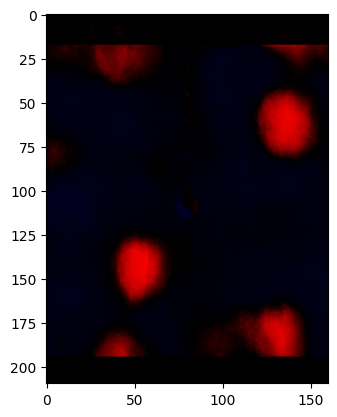

In [2]:
#shap_values = np.stack(shap_values)
shap_values = np.load("shap-video.npy")
shap_sum = shap_values.sum(axis=(4,1))
norm = np.abs(shap_sum).max()
red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
images = np.zeros((shap_values.shape[0], 210, 160, 3), dtype=np.float32)
images[:,:,:,0] = red
images[:,:,:,2] = blue
plt.imshow(images[0])
del shap_values

In [7]:
with Window("Shap", fps=15, scale=4.0) as window:
    for observation, shap_image in zip(observations, images):
        obs = observation.float() / 255
        window(np.hstack([obs, shap_image]))